# Data Exploration

Here, I'm going to explore creating heatmaps of where crimes occured. 

To do this, I found this Kaggle script written in R that I pulled inspiration from [this script.](https://www.kaggle.com/ldocao/sf-crime/population-density-heat-map/code). I also found [this](https://www.kaggle.com/ldocao/sf-crime/population-density-heat-map) python scipt that proved helpful.  

## Importing Everything

In [1]:
% matplotlib inline
import shapefile
import pandas as pd
import numpy as np
import itertools

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib import cm
from datetime import datetime
from ipywidgets import widgets  
from IPython.display import display


## Read in Data
Also, here, I'm converting the timestamp to a timetime object, as well as years, months, days, and hours

In [2]:
crimeData = pd.read_csv('train.csv')

crimeData['DateTime'] = crimeData['Dates'].apply(
    lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

crimeData['Year'] = crimeData['DateTime'].apply(lambda x: x.year)
crimeData['Month'] = crimeData['DateTime'].apply(lambda x: x.month)
crimeData['Day'] = crimeData['DateTime'].apply(lambda x: x.day)
crimeData['Hour'] = crimeData['DateTime'].apply(lambda x: x.hour)

crimeData

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,DateTime,Year,Month,Day,Hour
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015-05-13 23:53:00,2015,5,13,23
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015-05-13 23:53:00,2015,5,13,23
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,2015-05-13 23:33:00,2015,5,13,23
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,2015-05-13 23:30:00,2015,5,13,23
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,2015-05-13 23:30:00,2015,5,13,23
5,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM UNLOCKED AUTO,Wednesday,INGLESIDE,NONE,0 Block of TEDDY AV,-122.403252,37.713431,2015-05-13 23:30:00,2015,5,13,23
6,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,INGLESIDE,NONE,AVALON AV / PERU AV,-122.423327,37.725138,2015-05-13 23:30:00,2015,5,13,23
7,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,BAYVIEW,NONE,KIRKWOOD AV / DONAHUE ST,-122.371274,37.727564,2015-05-13 23:30:00,2015,5,13,23
8,2015-05-13 23:00:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,RICHMOND,NONE,600 Block of 47TH AV,-122.508194,37.776601,2015-05-13 23:00:00,2015,5,13,23
9,2015-05-13 23:00:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,CENTRAL,NONE,JEFFERSON ST / LEAVENWORTH ST,-122.419088,37.807802,2015-05-13 23:00:00,2015,5,13,23


## Get Count of Crimes by District 
Here, I want to create an interactive display that allows me to choose different categories and see how the number of crimes for each district (the selected crimes only) changes over time). I want to be able to specify both the types of crimes I want to look at and the year. 

To do this, I'm going to define a function that takes in a list of check boxes, and returns the dataframe of counts by police district for those crimes. 

In [3]:
def getCountsFromCategories (checkboxes, districtOrder):
    '''Given a list of checkboxes, this code takes all the selected checkboxes and counts the number of crimes that 
    occurred for each district.'''
    
    CrimesYearsDict = {}
    selectedCategories = []
    for crime in checkboxes:
        if (checkboxes[crime].value):
            selectedCategories.append(crime)
            
    crimeCountByDistrict = crimeData[crimeData.Category.isin(selectedCategories)].groupby(['PdDistrict','Year']).count().reset_index()
    years = range(2003, 2016)
    
    for year in years:
        districtColors = []
        for district in districtOrder:
            numCrimes = crimeCountByDistrict[
                (crimeCountByDistrict.Year == year) 
                & (crimeCountByDistrict.PdDistrict == district)]['Dates'].tolist()

            if (len(numCrimes) <1):
                numCrimes = [0]

            maxCrimeCount = crimeCountByDistrict[crimeCountByDistrict.Year == year]['Dates'].max()
            districtColors.append(1.0*numCrimes[0]/maxCrimeCount)



            colors = np.array(map(float,districtColors)) #convert to float

            CrimesYearsDict[year] = colors
    return CrimesYearsDict

In [4]:
def getDistrictOutlines (filename):
    '''get the district outlines and a list of the disrticts in the file above'''
    sf = shapefile.Reader(filename)

    policeDistricts = sf.shapeRecords()

    districtOrder = []
    districtShapes = []
    districtOutlines = []
    
    for district in policeDistricts:

        xDistrict = [i[0] for i in district.shape.points[:]]
        yDistrict = [i[1] for i in district.shape.points[:]]

        districtOrder.append(district.record[1])

        districtPolygon = Polygon(np.array([xDistrict,yDistrict]).T, closed=True) #get one single polygon
        districtShapes.append(districtPolygon)
        districtOutlines.append((xDistrict,yDistrict))
        
    return districtOrder, districtShapes, districtOutlines
    

In [5]:
crimeTypes = crimeData.Category.unique().tolist()
checkboxes = {}
for crime in crimeTypes:
    checkboxes[crime] = widgets.Checkbox(description=crime, value=False)
    display(checkboxes[crime])

### Creating Plot of Crimes by Police District
Here, I'm going to plot the number of crimes that occurred in each police district. 

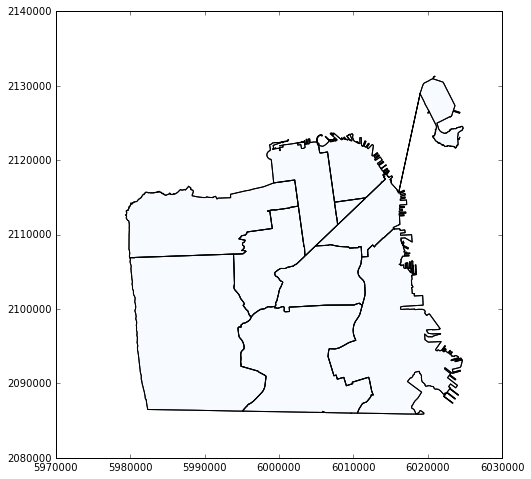

<function __main__.image_display>

In [6]:
def image_display(i):
    districtOrder, districtShapes, districtOutlines = getDistrictOutlines("./sfpd_districts/sfpd_districts.shp")
    
    CrimesYearsDict = getCountsFromCategories (checkboxes, districtOrder)
    
    fig, ax = plt.subplots(figsize=(8,8))
    for xDistrict, yDistrict in districtOutlines:
        plt.plot(xDistrict, yDistrict, 'k')
    
    p = PatchCollection(districtShapes, cmap="Blues")
    p.set_array(CrimesYearsDict[i])
    ax.add_collection(p)
    plt.axis('scaled')
    plt.show()


step_slider = widgets.IntSlider(min=2003, max=2015, value=2003)
widgets.interact(image_display, i=step_slider)

so, it seems like the (downtown?) is the district with the most crimes. (But that most of the crimes happen in the three districts that in the north eastern parts of SF. It also seems like the distribution of the crimes that occur in each district over the years aren't that different. (Maybe because more crimes occur in places with more people, and that doesn't really change over the years. 

Now, this graph isn't all that helpful... I'd like to actually get the districts normalized by the number of crimes that occurred in each district, as opposed to the number of crimes that occured each year. This might prove to be a more helpful visualization. (I will do this eventually)

## Now plotting by the number of crimes by time of day. 

I'm guessing that certain crimes are more likely to happen at various times of the day, so I'm going to plot the number of each crime that happened every hour. 

In [7]:
groupedByHour = crimeData.groupby(['Hour', 'Category']).count().reset_index()

<function __main__.image_display_hour>

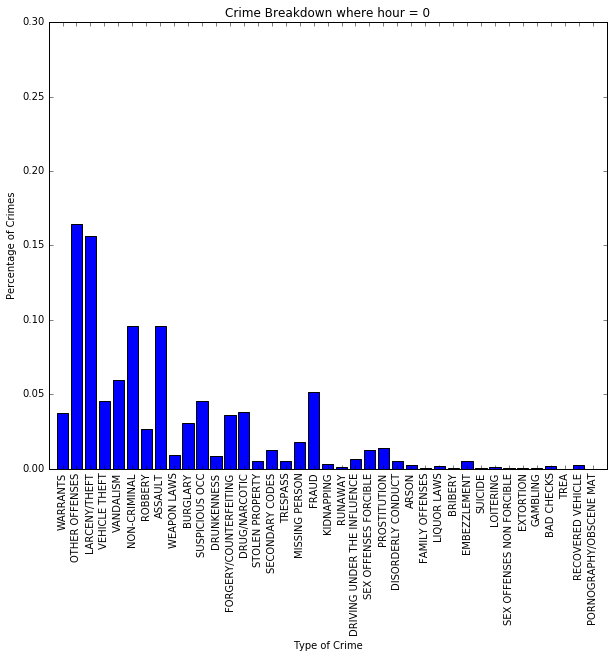

In [8]:
def image_display_hour(i):
    hour = i
    totalCrimes = sum(groupedByHour[groupedByHour.Hour == hour]['Dates'].tolist())
    crimeTypes = crimeData.Category.unique().tolist()
    crimeCountsPercent = []
    for crime in crimeTypes:
        countList = groupedByHour[(groupedByHour.Hour == hour) & (groupedByHour.Category == crime)]['Dates'].tolist()
        if (len(countList) > 0):
            count = countList[0]
        else:
            count = 0

        crimeCountsPercent.append(1.0*count/totalCrimes)

    plt.figure(figsize=(10,8))
    plt.bar([x + 0.1 for x in range(len(crimeCountsPercent))], crimeCountsPercent, width = 0.8)
    plt.xticks([x + 0.5 for x in range(len(crimeCountsPercent))], crimeTypes, rotation='vertical')
    plt.axis([-0.5, 39.5, 0 ,0.3])
    plt.title('Crime Breakdown where hour = ' + str(hour))
    plt.xlabel('Type of Crime')
    plt.ylabel('Percentage of Crimes')


step_slider = widgets.IntSlider(min=0, max=23, value=0)
widgets.interact(image_display_hour, i=step_slider)

So, it seems like the most common crimes are larcent/theft or other offenses. It, however, appears that these aren't as common in the early hours of the morning. Also, it appears that crime picks up in the evening time. 

Now, I want to see whether there's a similar pattern for days of the week.

In [9]:
groupedByDayOfWeek = crimeData.groupby(['DayOfWeek', 'Category']).count().reset_index()

<function __main__.image_display_day_of_week>

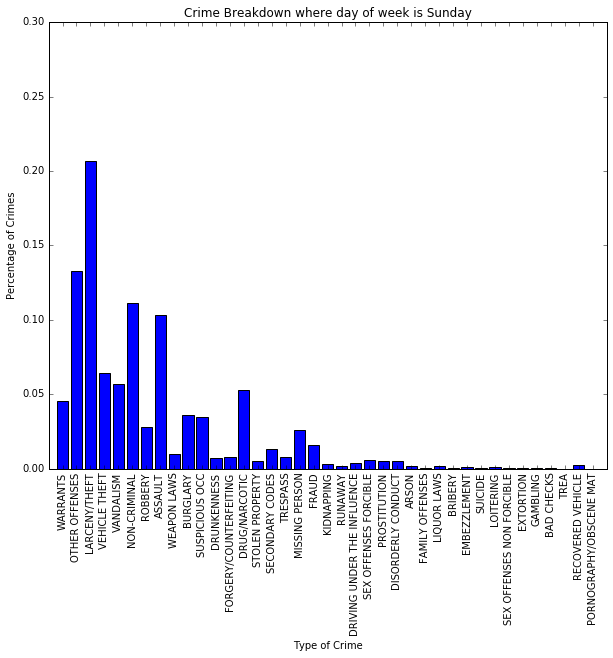

In [10]:
def image_display_day_of_week(i):
    dayOfWeek = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
    day = dayOfWeek[i]
    totalCrimes = sum(groupedByDayOfWeek[groupedByDayOfWeek.DayOfWeek == day]['Dates'].tolist())
    crimeTypes = crimeData.Category.unique().tolist()
    crimeCountsPercent = []
    for crime in crimeTypes:
        countList = groupedByDayOfWeek[(groupedByDayOfWeek.DayOfWeek == day) & (groupedByDayOfWeek.Category == crime)]['Dates'].tolist()
        if (len(countList) > 0):
            count = countList[0]
        else:
            count = 0

        crimeCountsPercent.append(1.0*count/totalCrimes)

    plt.figure(figsize=(10,8))
    plt.bar([x + 0.1 for x in range(len(crimeCountsPercent))], crimeCountsPercent, width = 0.8)
    plt.xticks([x + 0.5 for x in range(len(crimeCountsPercent))], crimeTypes, rotation='vertical')
    plt.axis([-0.5, 39.5, 0 ,0.3])
    plt.title('Crime Breakdown where day of week is ' + str(day))
    plt.xlabel('Type of Crime')
    plt.ylabel('Percentage of Crimes')


step_slider = widgets.IntSlider(min=0, max=6, value=0)
widgets.interact(image_display_day_of_week, i=step_slider)

It does, in fact seem like crime picks up over the weekend. Especially, theft and stuff.

So, now, I'm curious. Do different types of crime happen at different hours on different weeks? Now, I'm going to try to plot that.

First, I want to group by days of the week, then hour and then category. 

In [11]:
groupedByTime = crimeData.groupby(['DayOfWeek', 'Hour', 'Category']).count().reset_index()
groupedByTime

,DayOfWeek,Hour,Category,Dates,Descript,PdDistrict,Resolution,Address,X,Y,DateTime,Year,Month,Day
0,Friday,0,ARSON,14,14,14,14,14,14,14,14,14,14,14
1,Friday,0,ASSAULT,596,596,596,596,596,596,596,596,596,596,596
2,Friday,0,BAD CHECKS,15,15,15,15,15,15,15,15,15,15,15
3,Friday,0,BRIBERY,1,1,1,1,1,1,1,1,1,1,1
4,Friday,0,BURGLARY,191,191,191,191,191,191,191,191,191,191,191
5,Friday,0,DISORDERLY CONDUCT,29,29,29,29,29,29,29,29,29,29,29
6,Friday,0,DRIVING UNDER THE INFLUENCE,46,46,46,46,46,46,46,46,46,46,46
7,Friday,0,DRUG/NARCOTIC,246,246,246,246,246,246,246,246,246,246,246
8,Friday,0,DRUNKENNESS,43,43,43,43,43,43,43,43,43,43,43
9,Friday,0,EMBEZZLEMENT,45,45,45,45,45,45,45,45,45,45,45


Now, we want to create the heatmap!

[0, 168, 0, 39]

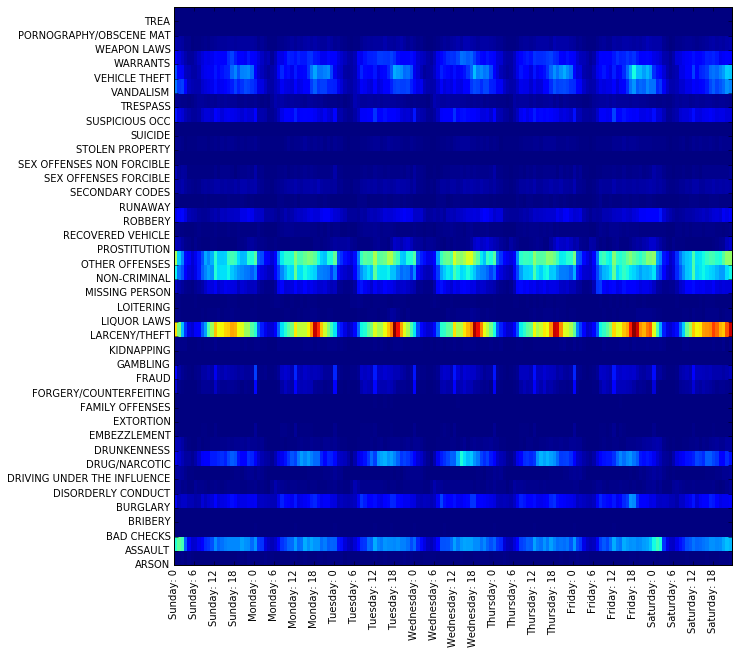

In [12]:
crimeCategories = groupedByTime.Category.unique().tolist()
daysOfWeek = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
hours = range(24)
daysOfWeekHours = list(itertools.product(daysOfWeek, hours))
daysOfWeekHoursString = [x[0] + ': ' + str(x[1]) for x in daysOfWeekHours]

numCrimes = np.zeros((len(crimeCategories), len(daysOfWeekHours)))


for i,crimeCategory in enumerate(crimeCategories):
    for j,time in enumerate(daysOfWeekHours):
        try:
            crimeCount = groupedByTime[(groupedByTime.DayOfWeek == time[0]) & 
                                       (groupedByTime.Hour == time[1]) & 
                                       (groupedByTime.Category == crimeCategory)]['Dates'].tolist()[0]
        except:
            crimeCount = 0
        
        
        numCrimes[i][j] = crimeCount
fig = plt.figure()
fig.set_size_inches(10,10)
plt.pcolor(numCrimes)
xticks = plt.xticks(range(0,len(daysOfWeekHoursString),6), daysOfWeekHoursString[0::6], rotation='vertical')
yticks = plt.yticks(range(len(crimeCategories)), crimeCategories)
plt.axis([0,len(daysOfWeekHoursString), 0, len(crimeCategories)])

Hmmm, so it seems like most things are relatively periodic, and that the most crimes are are either larceny/theft, other offenses,or non-crimal offinses. Additionally, it seems like more crimes happen on the weekends. This is a huge plot. Other helpful plots might be to see if there are certain crimes that are more common in a given district. 

This doesn't really seem to be a hugely helpful graph. Let's try doing one by crime category, where the x axis is the day of the week and the y axis is the hour

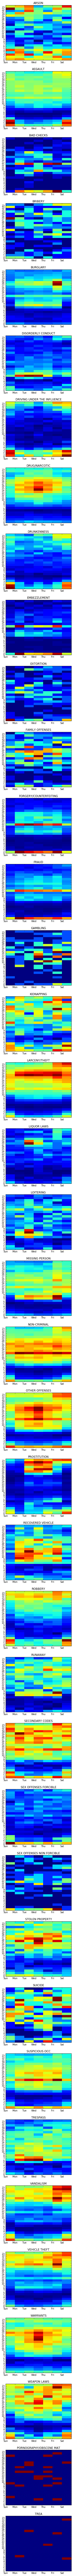

In [20]:
crimeCategories = groupedByTime.Category.unique().tolist()
daysOfWeek = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
daysOfWeekDisp = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
hours = range(24)

#Create all the subplots
f, subplots = plt.subplots(len(crimeCategories),figsize = (5, len(crimeCategories)*5))
plt.setp(subplots, xticks=range(len(daysOfWeek)), xticklabels=daysOfWeekDisp,
        yticks=range(len(hours)), yticklabels=hours)

##Create a plot for each crime. 
for p,crime in enumerate(crimeCategories):
    numCrimes = np.zeros((len(hours), len(daysOfWeek)))
    for i,hour in enumerate(hours):
        for j,dayOfWeek in enumerate(daysOfWeek):
            try:
                crimeCount = groupedByTime[(groupedByTime.DayOfWeek == dayOfWeek) & 
                                           (groupedByTime.Hour == hour) & 
                                           (groupedByTime.Category == crime)]['Dates'].tolist()[0]
            except:
                crimeCount = 0


            numCrimes[i][j] = crimeCount

    subplots[p].pcolor(numCrimes)
    subplots[p].set_title(crime)


So, it seems like some plots are very regular --- they are concentrated around some day of the week/time combination. Examples of these are Drug/Narcotic, Theft/assault. Others, like arson or bribery are much less predictable. So, as we're implementing a model, we'll have to account for the fact that some times predict certain categories, while others do not. Also, there are some crimes for which we just simply don't have much data, like treason, and pornograph/obscene materials. 